# Курсовой проект

Импорт библотек, необходимых для работы, а также служебных функций.

In [7]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'png'
warnings.filterwarnings('ignore')

In [8]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Импорт и подготовка данных к работе

In [10]:
data = pd.read_csv('train.csv')
data.rename(columns={"Helthcare_2":"Healtcare_2"}, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healtcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [12]:
reduce_mem_usage(data)
data.info()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 no

In [13]:
target_mean = round(data['Price'].mean(), 2)
target_median = data['Price'].median()
target_mode = data['Price'].mode()[0]

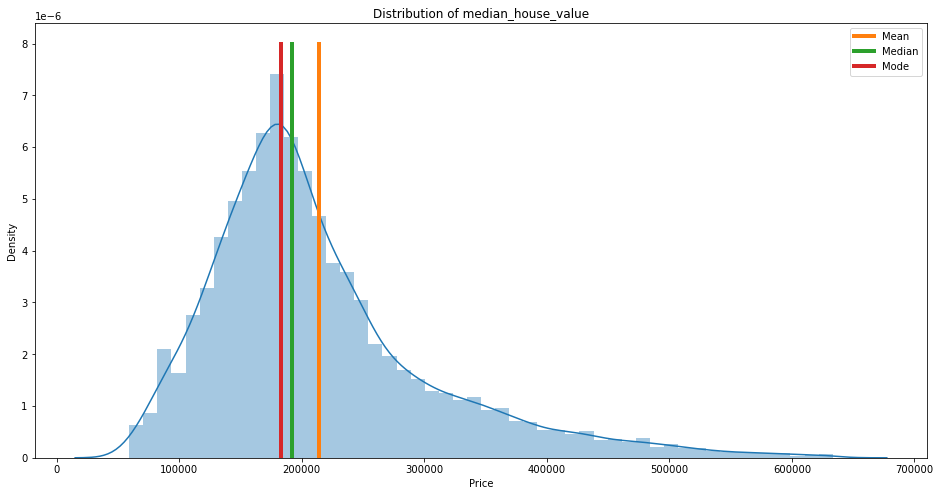

In [14]:
plt.figure(figsize = (16, 8))

sns.distplot(data['Price'], bins=50)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [15]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healtcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [16]:
data_num_feat = data.select_dtypes(include=('int8', 'int16', 'int32', 'float32'))
data_num_feat.drop('Price', axis=1, inplace=True)
data_num_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   DistrictId     10000 non-null  int16  
 2   Rooms          10000 non-null  float32
 3   Square         10000 non-null  float32
 4   LifeSquare     7887 non-null   float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int8   
 7   HouseFloor     10000 non-null  float32
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Social_1       10000 non-null  int8   
 11  Social_2       10000 non-null  int16  
 12  Social_3       10000 non-null  int16  
 13  Healthcare_1   5202 non-null   float32
 14  Healtcare_2    10000 non-null  int8   
 15  Shops_1        10000 non-null  int8   
dtypes: float32(7), int16(4), int32(1), int8(4)
memory usage: 429.8 KB


В данных присутствуют "выбросы" и пропущенные значения

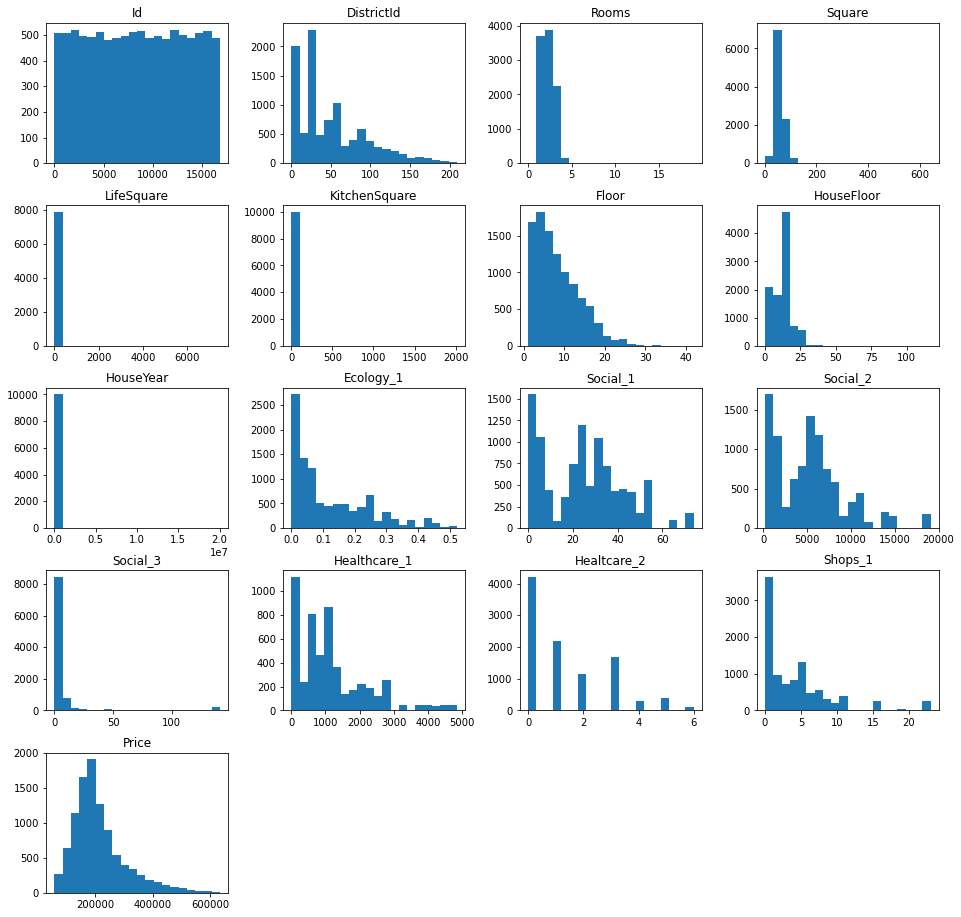

In [17]:
data.hist(figsize=(16,16), bins=20, grid=False);

#### Очистка пропущенных значений NaN

In [18]:
data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healtcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [19]:
data.loc[data['LifeSquare'].isna(), 'LifeSquare'] = data['LifeSquare'].median()
data.loc[data['Healthcare_1'].isna(), 'Healthcare_1'] = data['Healthcare_1'].median()

#### Очистка выбросов

Количество комнат

In [20]:
data.loc[(data['Rooms'] == 0) | (data['Rooms'] > 9), 'Rooms'] = data['Rooms'].median()

Площадь и площадь кухни

In [21]:
data.loc[(data['Square'] > 250) | (data['Square'] < 10), 'Square'] = data['Square'].median()

In [22]:
data.loc[(data['LifeSquare'] > 250) | (data['LifeSquare'] < 2), 'LifeSquare'] = data['LifeSquare'].median()
data.loc[(data['KitchenSquare'] > 250) | (data['KitchenSquare'] < 2), 'KitchenSquare'] = data['KitchenSquare'].median()

Убираем дома с околонулевым количеством этажей, а также квартитры, которые "вышли" за пределы дома

In [23]:
data.loc[(data['HouseFloor'] < data['Floor']) & (data['HouseFloor'] < 3), 'HouseFloor'] = data['HouseFloor'].median()
data.loc[(data['HouseFloor'] < data['Floor']) & (abs(data['HouseFloor'] - data['Floor']) < 2), ['HouseFloor', 'Floor']] = data['HouseFloor'].median() 

Год основания дома

In [24]:
data.loc[(data['HouseYear'] > 2022) | (data['HouseYear'] < 1910), 'HouseYear'] = data['HouseYear'].median()

Категориальные признаки

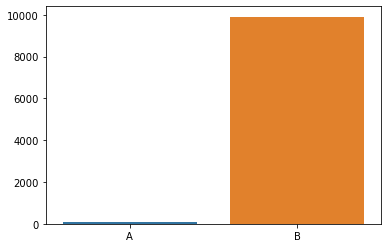

In [25]:
eco2_counts = data['Ecology_2'].value_counts()
sns.barplot(eco2_counts.index, eco2_counts.values)
plt.show()

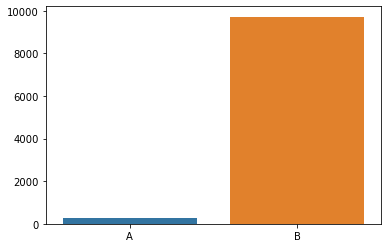

In [26]:
eco3_counts = data['Ecology_3'].value_counts()
sns.barplot(eco3_counts.index, eco3_counts.values)
plt.show()

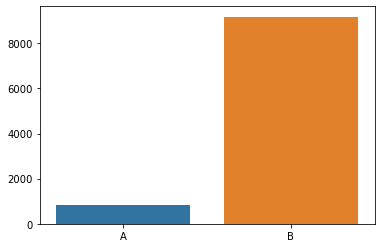

In [27]:
shops2_counts = data['Shops_2'].value_counts()
sns.barplot(shops2_counts.index, shops2_counts.values)
plt.show()

In [28]:
data = pd.concat([data, pd.get_dummies(data['Ecology_2'])], axis=1)
data.rename({'A':'Eco_2_A', 'B':'Eco_2_B'}, axis='columns', inplace=True)
data = pd.concat([data, pd.get_dummies(data['Ecology_3'])], axis=1)
data.rename({'A':'Eco_3_A', 'B':'Eco_3_B'}, axis='columns', inplace=True)
data = pd.concat([data, pd.get_dummies(data['Shops_2'])], axis=1)
data.rename({'A':'Shops_2_A', 'B':'Shops_2_B'}, axis='columns', inplace=True)

In [29]:
data.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Id'], axis=1, inplace=True)

Матрицу корреляций построим, почему нет?

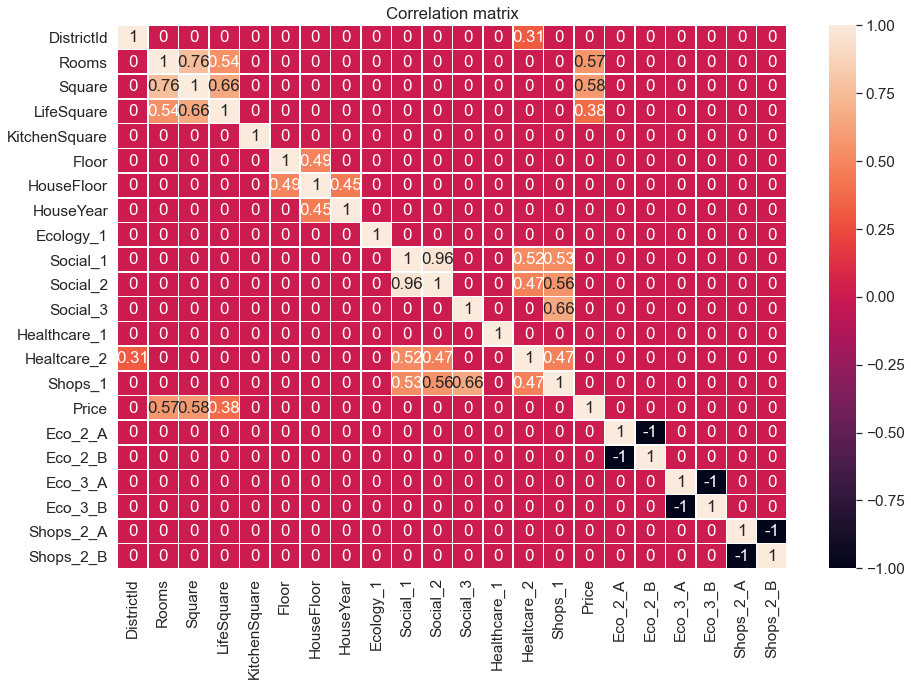

In [30]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = data.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='rocket')
plt.title('Correlation matrix')
plt.show()

Возможно, стоит убрать Social и рассмотреть объединение Rooms, Square и LifeSquare

#### На основании проведённого анализа подготовим класс

В классе два метода избавления от выбросов. Первый согласно проведённой выше работе, второй более грубый, убирающий значения Выбивающиеся за указанный процент. Пробовал использовать оба, но более грубый показал себя хуже.

In [31]:
class ImproveData():
    def __init__(self, data, fix=1):
        self.data = data
        self.fix = fix
        self.reduce_mem_usage()
        self.fill_na()
        self.fix_categories()
        if fix == 1:
            self.fix_outliers()
        elif fix == 2:
            self.fix_outliers_quantiles()
        
        self.data.rename(columns={"Helthcare_2":"Healtcare_2"}, inplace=True)

            
    
    def reduce_mem_usage(self):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.        
        """
        df = self.data
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        self.data = df

    def fill_na(self):
        na_list = self.data.isna().sum()
        for feature in na_list[na_list > 0].index:
            self.data.loc[self.data[feature].isna(), feature] = self.data[feature].median()
    
    def fix_outliers(self):
        self.data.loc[(self.data['Rooms'] == 0) | (self.data['Rooms'] > 9), 'Rooms'] = self.data['Rooms'].median()
        self.data.loc[(self.data['Square'] > 250) | (self.data['Square'] < 10), 'Square'] = self.data['Square'].median()
        self.data.loc[(self.data['LifeSquare'] > 250) | (self.data['LifeSquare'] < 2), 'LifeSquare'] = self.data['LifeSquare'].median()
        self.data.loc[(self.data['KitchenSquare'] > 250) | (self.data['KitchenSquare'] < 2), 'KitchenSquare'] = self.data['KitchenSquare'].median()
        self.data.loc[(self.data['HouseFloor'] < self.data['Floor']) & (self.data['HouseFloor'] < 3), 'HouseFloor'] = self.data['HouseFloor'].median()
        self.data.loc[(self.data['HouseFloor'] < self.data['Floor']) & (abs(self.data['HouseFloor'] - self.data['Floor']) < 2), ['HouseFloor', 'Floor']] = self.data['HouseFloor'].median() 
        self.data.loc[(self.data['HouseYear'] > 2022) | (self.data['HouseYear'] < 1910), 'HouseYear'] = self.data['HouseYear'].median()
    
    def fix_outliers_quantiles(self, cut_percent=5):
        set_for_drop = set()
        for feature in self.data.columns:
            q_down = self.data[feature].quantile(q=(cut_percent/2)/100)
            q_up = self.data[feature].quantile(q=(100-(cut_percent/2))/100)
            set_for_drop.update(set(self.data.loc[(self.data[feature] > q_up) | (self.data[feature] < q_down)].index))
        print(f'Выброшено {len(set_for_drop) / len(self.data)*100}% строк.')
        print(len(set_for_drop))
        self.data.drop(index=set_for_drop, inplace=True)
        
    
    def fix_categories(self):
        self.data = pd.concat([self.data, pd.get_dummies(self.data['Ecology_2'])], axis=1)
        self.data.rename({'A':'Eco_2_A', 'B':'Eco_2_B'}, axis='columns', inplace=True)
        self.data = pd.concat([self.data, pd.get_dummies(self.data['Ecology_3'])], axis=1)
        self.data.rename({'A':'Eco_3_A', 'B':'Eco_3_B'}, axis='columns', inplace=True)
        self.data = pd.concat([self.data, pd.get_dummies(self.data['Shops_2'])], axis=1)
        self.data.rename({'A':'Shops_2_A', 'B':'Shops_2_B'}, axis='columns', inplace=True)
        self.data.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Id'], axis=1, inplace=True)
    
    def save_data(self):
        with open('init_prep_data', 'wb') as f:
            pickle.dump(data, f)


In [32]:
alt_data = ImproveData(pd.read_csv('train.csv'), fix=1).data

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


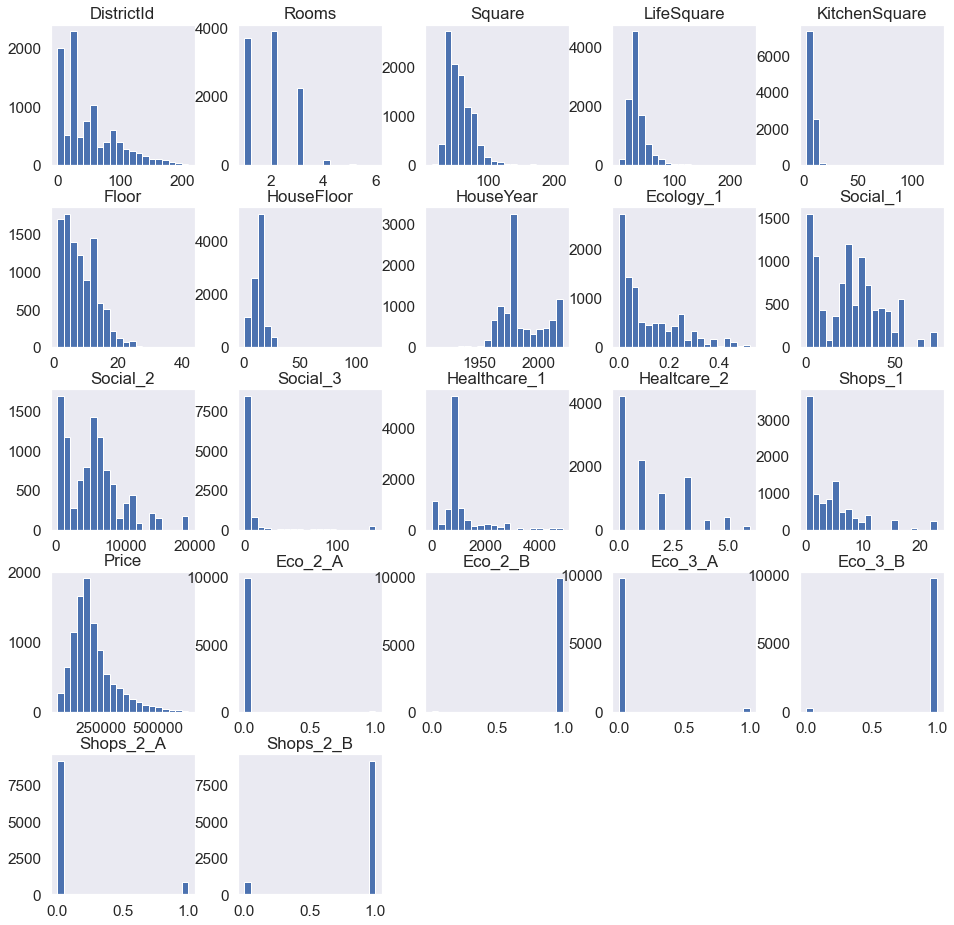

In [33]:
alt_data.hist(figsize=(16,16), bins=20, grid=False);

In [34]:
data.equals(alt_data)

True

Чудесно, работает!

Сохраним данные, на всякий случай

In [36]:
with open('init_prep_data', 'wb') as f:
    pickle.dump(alt_data, f)

In [37]:
with open('init_prep_data', 'rb') as f:
    alt_data = pickle.load(f)

## Обучение модели

In [38]:
X = alt_data.drop('Price', axis=1)

In [39]:
Y = alt_data['Price']

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [46]:
from catboost import CatBoostRegressor
import catboost
from catboost import datasets, metrics
from catboost import *

model = CatBoostRegressor(
    iterations=10000,
    random_seed=63,
    learning_rate=0.01,
    early_stopping_rounds=500
)
model.fit(
    X_train, Y_train,
    eval_set=(X_test, Y_test),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2:	0.859
RMSE:	34357.945
MSE:	1180468384.158


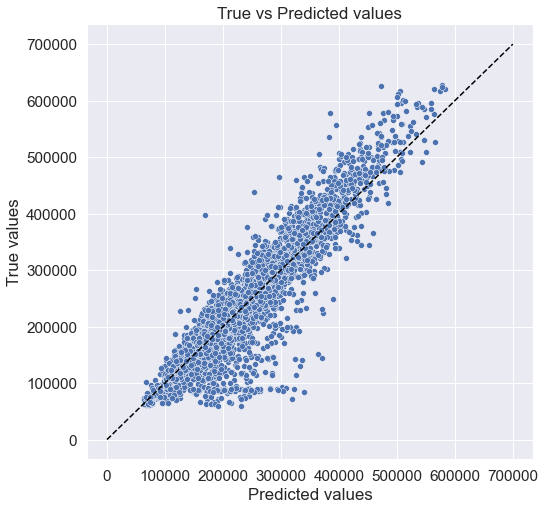

In [48]:
Y_train_preds = model.predict(X_train)
evaluate_preds(Y_train, Y_train_preds)

In [ ]:
Y_train_preds = model.predict(X_test)
evaluate_preds(Y_train, Y_test_preds)

In [175]:
X_train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Healtcare_2', 'Shops_1', 'Eco_2_A',
       'Eco_2_B', 'Eco_3_A', 'Eco_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [176]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [177]:
X_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Healtcare_2,Shops_1,Eco_2_A,Eco_2_B,Eco_3_A,Eco_3_B,Shops_2_A,Shops_2_B
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,0.280704,-0.114571,0.145753,0.163701,0.503524,0.059968,0.082304,0.294742,0.259037,-0.012052,...,1.181257,0.769379,0.153643,0.296821,0.010143,-0.010143,0.026857,-0.026857,0.084286,-0.084286
std,0.778375,0.809830,0.780218,0.997072,1.336575,0.567343,0.698528,0.706086,0.675432,0.585189,...,4.707430,4.653147,0.743838,1.192050,0.100207,0.100207,0.161677,0.161677,0.277836,0.277836
min,-0.616071,-1.000000,-1.616909,-1.981792,-1.333333,-0.777778,-1.500000,-2.500000,-0.408034,-0.833333,...,-0.400000,-5.625000,-0.500000,-0.750000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
25%,-0.276786,-1.000000,-0.448330,-0.455631,0.000000,-0.444444,-0.500000,-0.115385,-0.308244,-0.633333,...,-0.400000,-0.437500,-0.500000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.723214,0.000000,0.551670,0.544369,1.000000,0.555556,0.500000,0.884615,0.691756,0.366667,...,0.600000,0.562500,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.116071,3.000000,6.177457,12.984636,35.333333,3.777778,13.000000,1.653846,2.542998,1.633333,...,27.800000,24.681250,2.500000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000


Наиболее предпочтительным показалось использовать GradientBoostingRegressor. Но для начала найдём наиболее подходящие параметры

In [178]:
# %%time

# gb_model = GradientBoostingRegressor(criterion='mse',
#                          # min_samples_leaf=10,
#                           random_state=42,
#                          # n_estimators=100,
#                          # max_depth=7
#                          )

# params = {'n_estimators':[x for x in range(50,301,50)], 
#           'max_depth':[x for x in range(3,13,2)],
#           'min_samples_leaf':[x for x in range(5,16,5)]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, Y_train)

Wall time: 3min 59s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='r2')

In [179]:
print(gs.best_params_, gs.best_score_)

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 250} 0.7367503266759906


R2:	0.909
RMSE:	27547.19
MSE:	758847688.846


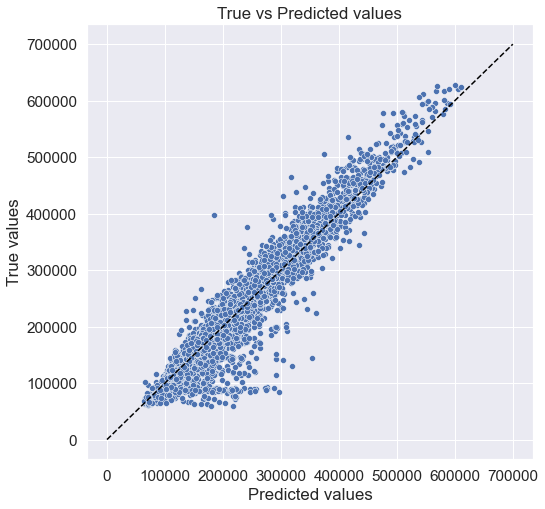

In [184]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=5,
                                     random_state=42,  
                                     n_estimators=250)
gb_model.fit(X_train, Y_train)

Y_train_preds = gb_model.predict(X_train)
evaluate_preds(Y_train, Y_train_preds)

R2:	0.747
RMSE:	48227.192
MSE:	2325862060.432


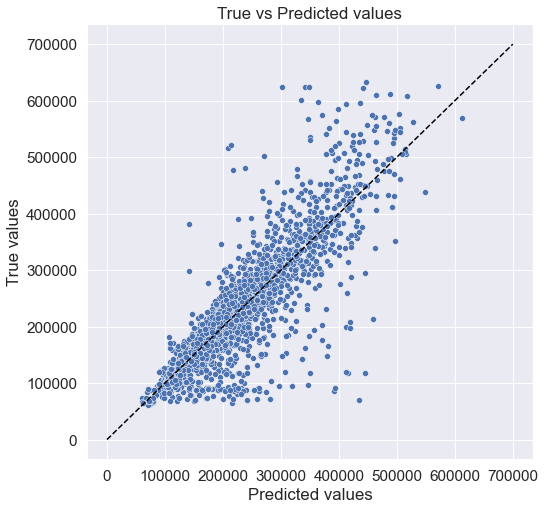

In [185]:
Y_test_preds = gb_model.predict(X_test)
evaluate_preds(Y_test, Y_test_preds)

## Итоговое предсказание

In [187]:
test_data = pd.read_csv('test.csv')

In [188]:
test_data.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
5,868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
6,672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
7,2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,B,B,33,7425,1,NaN,2,5,B
8,4510,1,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B
9,8354,62,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,B,B,39,7614,3,NaN,1,5,A


In [189]:
id_series = test_data['Id']
print(id_series)

0        4567
1        5925
2         960
3        3848
4         746
        ...  
4995    10379
4996    16138
4997     3912
4998     5722
4999    11004
Name: Id, Length: 5000, dtype: int64


In [190]:
test_data = ImproveData(test_data, fix=1).data

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [191]:
X_main_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

In [192]:
Y_main_pred = gb_model.predict(X_main_test)

In [193]:
# result_pred = pd.DataFrame(id_series,Y_main_pred], columns=['Id', 'Price'])
# result_pred = pd.DataFrame(id_series, columns=['Id'])
# result_pred.concat(pd.DataFrame(Y_main_pred, columns=['Price']))
Y_main_pred = pd.Series(Y_main_pred, name='Price')
result_pred = pd.concat([id_series, Y_main_pred], axis=1)
result_pred.head(10)

,Id,Price
0,4567,163875.368771
1,5925,122553.221170
2,960,138210.667691
3,3848,126249.372990
4,746,202342.496045
5,868,351552.702064
6,672,110411.806710
7,2471,219393.944460
8,4510,130273.061037
9,8354,278777.209736


In [194]:
result_pred.to_csv('result_pred_3.csv', index=False)